In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.stats import norm
import scipy.constants as scp
from tabulate import tabulate

---

# Auswertung Kompensationsmessung

In [2]:
#messwerte:
U_H1 = 5.35
dU_H = 0.010
I_H1 = 5 * 1.13
dI_H = 5 * 0.01
U_M1 = 24.00
dU_M = 0.1
I_M1 = 1.70
dI_M = 0.05
f1 = (1/60) * 291.0 #1/s
df = (1/60) * 1.0 
T_ab1 = 20.30
T_zu1 = 17.40
dT_fl = 0.1
V_1 = np.array([289.1, 288.4, 288.5, 290.4, 286.5])

V1 = np.mean(V_1) * 10**(-6) /60 #m^3/s
dV1 = np.std(V_1, ddof=1)/np.sqrt(len(V_1)) * 10**(-6) /60

print('V_1 =', V1, '+/-', dV1)

V_1 = 4.809666666666667e-06 +/- 1.0506611674982956e-08


In [3]:
#Heizleistung bzw Kälteleistung:
P1 = U_H1 * I_H1
dP1 = np.sqrt((U_H1 * dI_H)**2 + (dU_H * I_H1)**2)

#entzogene Wärme:
Q2 = P1/f1
dQ2 = Q2 * np.sqrt((dP1/P1)**2 + (df/f1)**2)

#reingesteckte Wärme:
T_diff1 = T_ab1 - T_zu1
dT_diff1 = np.sqrt(2 * dT_fl**2)
rho_w = 1000 #Dichte Wasser [kg/m^3]
c_w = 4180 #Wärmekap Wasser [J/kgK]
Q1 = c_w * rho_w * T_diff1 * V1 /f1
dQ1 = Q1 * np.sqrt((dT_diff1/T_diff1)**2 + (dV1/V1)**2 + (df/f1)**2)

#Mechanische Arbeit:
W_m = U_M1 * I_M1 /f1
dW_m = W_m * np.sqrt((dU_M/U_M1)**2 + (dI_M/I_M1)**2 + (df/f1)**2)

#Leistungsgrad:
eta1 = Q2/W_m
deta1 = eta1 * np.sqrt((dQ2/Q2)**2 + (dW_m/W_m)**2)

print('Delta T_1 =', T_diff1, '+/-', dT_diff1)
print('P_1 =', P1, '+/-', dP1)
print('Q_2 =', Q2, '+/-', dQ2)
print('Q_1 =', Q1, '+/-', dQ1)
print('W_m =', W_m, '+/-', dW_m)
print('eta_1 =', eta1, '+/-', deta1)

Delta T_1 = 2.900000000000002 +/- 0.14142135623730953
P_1 = 30.227499999999996 +/- 0.2734017190874995
Q_2 = 6.232474226804123 +/- 0.06030299601977805
Q_1 = 12.021191615120285 +/- 0.5882653674256575
W_m = 8.412371134020619 +/- 0.2515597237020738
eta_1 = 0.7408700980392156 +/- 0.0232854833762788


In [4]:
#Energiebilanz: (Q1 = Q2 + W_m)
print('Q_1 =', Q1, '+/-', dQ1)
print('Q_2 + W_m =', Q2+W_m, '+/-', np.sqrt(dQ2**2 + dW_m**2))
print('Sign = ', np.abs(Q1 - (Q2 + W_m))/np.sqrt(dQ1**2 + dQ2**2 + dW_m**2))

Q_1 = 12.021191615120285 +/- 0.5882653674256575
Q_2 + W_m = 14.644845360824743 +/- 0.25868657854250016
Sign =  4.082673939416114


# Kältemaschine/Wärmepumpe

In [5]:
def comma_to_float(valstr):
    return float(valstr.decode("utf-8").replace(',', '.'))

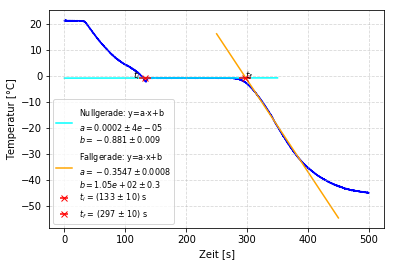

In [6]:
#Temperaturverlauf kühlen:
time1, temp1 = np.loadtxt('./A3 1.txt', skiprows=5,
                              converters={0:comma_to_float, 1:comma_to_float},
                              comments='>', unpack=True)

def linear(x, a, b):
    return a * x + b

Nullopt, Nullcov = curve_fit(linear, time1[1500:2500], temp1[1500:2500])
BELOWopt, BELOWcov = curve_fit(linear, time1[3200:4000], temp1[3200:4000])

#%matplotlib ipympl
plt.plot(time1[:5000], temp1[:5000], color='blue', zorder=0)
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('Zeit [s]')
plt.ylabel('Temperatur [°C]')
x1 = np.linspace(0, 350, 100)
x2 = np.linspace(250, 450, 100)
plt.plot(x1, linear(x1,*Nullopt), color='cyan', zorder=1, 
        label="\n".join(["Nullgerade: y=a$\cdot$x+b", 
                          r'$a={:.1}\pm{:.1}$'.format(Nullopt[0], np.sqrt(Nullcov[0][0])), 
                          r'$b={:.3}\pm{:.1}$'.format(Nullopt[1], np.sqrt(Nullcov[1][1]))]))
plt.plot(x2, linear(x2,*BELOWopt), color='orange', zorder=1,
        label="\n".join(["Fallgerade: y=a$\cdot$x+b", 
                          r'$a={:.4f}\pm{:.1}$'.format(BELOWopt[0], np.sqrt(BELOWcov[0][0])), 
                          r'$b={:.3}\pm{:.1}$'.format(BELOWopt[1], np.sqrt(BELOWcov[1][1]))]))
plt.errorbar(x=133, y=Nullopt[1], fmt='x', xerr=10, color='red', zorder=2,
            label='$t_i$ = (133 $\pm$ 10) s')
plt.errorbar(x=297, y=Nullopt[1], fmt='x', xerr=10, color='red', zorder=2,
            label='$t_f$ = (297 $\pm$ 10) s')
plt.text(113, Nullopt[1], '$t_i$', fontsize=9, color='k', zorder=2)
plt.text(297, Nullopt[1], '$t_f$', fontsize=9, color='k', zorder=2)
plt.legend(loc='lower left', prop={'size': 8})
plt.savefig('./output/Kuelung.pdf', format='PDF')

In [7]:
#Gerfrierzeit; abgelesen aus dem Diagramm:
t_i = 133.0
t_f = 297.0
T_freeze = t_f - t_i
dT_freeze = np.sqrt(2 * 10**2)

print('Gefrierzeit =', T_freeze, '+/-', dT_freeze)

Gefrierzeit = 164.0 +/- 14.142135623730951


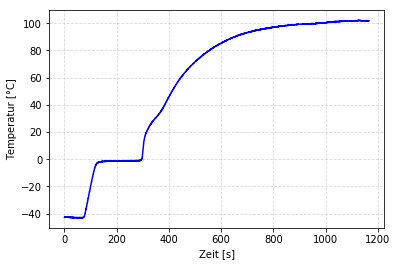

In [8]:
#Temperaturverlauf heizen:
time2, temp2 = np.loadtxt('./A3 2.txt', skiprows=5,
                              converters={0:comma_to_float, 1:comma_to_float},
                              comments='>', unpack=True)
plt.plot(time2, temp2, color='blue')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('Zeit [s]')
plt.ylabel('Temperatur [°C]')
plt.savefig('./output/Heizung.pdf', format='PDF')

In [9]:
#Kälteleistung berechnen:
lambH2O = 335 * 10**3 #spezifische schmelzwärme Wasser [J/kg]
VolW = 1 * 10**(-6) #Wasservolumen [m^3]
dVolW = 0.05 * 10**(-6)
m_W = VolW * rho_w #Wassermasse [kg]
dm_W = rho_w * dVolW

P2 = lambH2O * m_W /T_freeze
dP2 = P2 * np.sqrt((dm_W/m_W)**2 + (dT_freeze/T_freeze)**2)

print('P_2 =', P2, '+/-', dP2)
print('Sign = ', np.abs(P1 - P2)/np.sqrt(dP1**2 + dP2**2))

P_2 = 2.042682926829268 +/- 0.2036140969398576
Sign =  82.67966362710123


# Wärmekraftmaschine

In [10]:
#Leerlaufmessung:
U_Hl = 12.31
dU_H = 0.012
I_Hl = 5 * 2.720
dI_H = 5 * 0.01
fl = (1/60) * 297.5 #1/s
df = (1/60) * 0.5 
T_abl = 22.4
T_zul = 17.5
dT_fl = 0.1
V_l = np.array([287.5, 290.2, 291.0, 287.7, 289.4]) #ml/min
A_l = np.array([24040, 23960, 23480]) #hPa cm^3

T_diffl = T_abl - T_zul
dT_diffl = np.sqrt(2 * dT_fl**2)

Vl = np.mean(V_l) * 10**(-6) /60 #m^3/s
dVl = np.std(V_l, ddof=1)/np.sqrt(len(V_l)) * 10**(-6) /60
Al = np.mean(A_l) * 10**(-4) #Pa m^3
dAl = np.std(A_l, ddof=1)/np.sqrt(len(A_l)) * 10**(-4)

print('T_diff =', T_diffl, '+/-', dT_diffl)
print('Volumenfluss leer =', Vl, '+/-', dVl)
print('Fläche pV leer =', Al, '+/-', dAl)

T_diff = 4.899999999999999 +/- 0.14142135623730953
Volumenfluss leer = 4.819333333333333e-06 +/- 1.1433381924094995e-08
Fläche pV leer = 2.3826666666666667 +/- 0.017486502731472005


In [11]:
#Zu bestimmende Parameter:
#el. Leistung
P_el = I_Hl * U_Hl 
dP_el = P_el * np.sqrt((dU_H/U_Hl)**2 + (dI_H/I_Hl)**2)
#el. Wärme
Q_el = P_el/fl 
dQ_el = Q_el * np.sqrt((dP_el/P_el)**2 + (df/fl)**2)
#abgeführte Leistung
P_ab = c_w * rho_w * T_diffl * Vl 
dP_ab = P_ab * np.sqrt((dT_diffl/T_diffl)**2 + (dVl/Vl)**2)
#abgeführte Wärme
Q_ab = P_ab/fl 
dQ_ab = Q_ab * np.sqrt((dP_ab/P_ab)**2 + (df/fl)**2)
#Leistung Motor
P_pV = Al * fl
dP_pV = P_pV * np.sqrt((dAl/Al)**2 + (df/fl)**2)
#Wärme Motor
Q_pV = Al
dQ_pV = dAl
#therm Wirkungsgrad
eta_th = Al/Q_el
deta_th = eta_th * np.sqrt((dAl/Al)**2 + (dQ_el/Q_el)**2)

print('P_el = (', P_el, '+/-', dP_el, ') W')
print('Q_el = (', Q_el, '+/-', dQ_el, ') J')
print('P_ab = (', P_ab, '+/-', dP_ab, ') W')
print('Q_ab = (', Q_ab, '+/-', dQ_ab, ') J')
print('P_pV = (', P_pV, '+/-', dP_pV, ') W')
print('Q_pV = (', Q_pV, '+/-', dQ_pV, ') J')
print('eta_th =', eta_th, '+/-', deta_th)

P_el = ( 167.41600000000003 +/- 0.6367687884939086 ) W
Q_el = ( 33.764571428571436 +/- 0.14040283162954967 ) J
P_ab = ( 98.7095853333333 +/- 2.8585152908353977 ) W
Q_ab = ( 19.907815529411756 +/- 0.5774773782700336 ) J
P_pV = ( 11.814055555555555 +/- 0.0889483613545203 ) W
Q_pV = ( 2.3826666666666667 +/- 0.017486502731472005 ) J
eta_th = 0.07056706381442367 +/- 0.000595248870269635


In [12]:
#Motorverlust:
Q_v = Q_el - Q_ab - Q_pV
dQ_v = np.sqrt(dQ_el**2 + dQ_ab**2 + dQ_pV**2)

print('Q_v = (', Q_v, '+/-', dQ_v, ') J')

Q_v = ( 11.474089232493013 +/- 0.5945576972178603 ) J


In [13]:
#Messungen mit Bremse:
F1 = 0.82
U1 = 12.3
I1 = 2.72 * 5
A_1 = np.array([32150, 31950, 32070]) * 10**(-4)
f_1 = (1/60) * np.array([223.9, 223.5, 223.4])

F2 = 0.61
U2 = 12.32
I2 = 2.72 * 5
A_2 = np.array([30620, 30220, 30370]) * 10**(-4)
f_2 = (1/60) * np.array([251.6, 251.0, 250.8])

F3 = 0.40
U3 = 12.31
I3 = 2.72 * 5
A_3 = np.array([28080, 27820, 28320]) * 10**(-4)
f_3 = (1/60) * np.array([283.8, 283.1, 284.2])

F4 = 0.19
U4 = 12.3
I4 = 2.72 * 5
A_4 = np.array([26050, 25330, 25520]) * 10**(-4)
f_4 = (1/60) * np.array([304.1, 305.7, 305.6])

dF_ = 0.03
dU_ = 0.02
dI_ = 0.01
df_ = (1/60) * 0.5

l = 0.25 #Halbe Länge Bremszaum

#Arrays:
F = np.array([F1, F2, F3, F4])
U = np.array([U1, U2, U3, U4])
I = np.array([I1, I2, I3, I4])
A = np.array([np.mean(A_1), np.mean(A_2), np.mean(A_3), np.mean(A_4)])
ff = np.array([np.mean(f_1), np.mean(f_2), np.mean(f_3), np.mean(f_4)])

def errf(f):
    return np.sqrt((np.std(f, ddof=1)/np.sqrt(len(f)))**2 + df_**2)

dF = np.full(4, dF_)
dU = np.full(4, dU_)
dI = np.full(4, dI_)
dA = np.array([np.std(A_1, ddof=1)/np.sqrt(len(A_1)), 
               np.std(A_2, ddof=1)/np.sqrt(len(A_2)), 
               np.std(A_3, ddof=1)/np.sqrt(len(A_3)), 
               np.std(A_4, ddof=1)/np.sqrt(len(A_4))])
dff = np.array([errf(f_1), errf(f_2), errf(f_3), errf(f_4)])

In [14]:
#Tabelle
header1 = ['F', 'dF', 'U', 'dU', 'I', 'dI', 'A', 'dA', 'f', 'df']
tab1 = zip(F, dF, U, dU, I, dI, A, dA, ff, dff)

print(tabulate(tab1, headers=header1, tablefmt="latex"))

\begin{tabular}{rrrrrrrrrr}
\hline
    F &   dF &     U &   dU &    I &   dI &       A &         dA &       f &         df \\
\hline
 0.82 & 0.03 & 12.3  & 0.02 & 13.6 & 0.01 & 3.20567 & 0.00581187 & 3.72667 & 0.00871355 \\
 0.61 & 0.03 & 12.32 & 0.02 & 13.6 & 0.01 & 3.04033 & 0.0116667  & 4.18556 & 0.00924629 \\
 0.4  & 0.03 & 12.31 & 0.02 & 13.6 & 0.01 & 2.80733 & 0.0144376  & 4.72833 & 0.00990697 \\
 0.19 & 0.03 & 12.3  & 0.02 & 13.6 & 0.01 & 2.56333 & 0.0215432  & 5.08556 & 0.0119928  \\
\hline
\end{tabular}


In [15]:
#Berchnung von Q_el, W_pV, W_D, eta_th, eta_eff:
#elektrische Wärme
Q_elX = U * I /ff
dQ_elX = Q_elX * np.sqrt((dU/U)**2 + (dI/I)**2 + (dff/ff)**2)
#mechanische Arbeit
W_pVX = A
dW_pVX = dA
W_D = 2 * np.pi * l * F
dW_D = 2 * np.pi * l * dF
#Wirkungsgrade:
eta_th = W_pVX/Q_elX
deta_th = eta_th * np.sqrt((dW_pVX/W_pVX)**2 + (dQ_elX/Q_elX)**2)
eta_eff = W_D/Q_elX
deta_eff = eta_eff * np.sqrt((dW_D/W_D)**2 + (dQ_elX/Q_elX)**2)

In [16]:
#Tabelle
header2 = ['nr.', 'Q_el', 'dQ_el', 'W_pV', 'dW_pV', 'W_D', 'dW_D', 'eta_th', 'deta_th', 'eta_eff', 'deta_eff']
tab2 = zip(np.arange(1, 5), np.round(Q_elX, 2), np.round(dQ_elX, 2), np.round(W_pVX, 3), np.round(dW_pVX, 3), np.round(W_D, 3), np.round(dW_D, 3), np.round(100*eta_th, 3), np.round(100*deta_th, 3), np.round(100*eta_eff, 2), np.round(100*deta_eff, 2))

print(tabulate(tab2, headers=header2, tablefmt="latex"))

\begin{tabular}{rrrrrrrrrrr}
\hline
   nr. &   Q\_el &   dQ\_el &   W\_pV &   dW\_pV &   W\_D &   dW\_D &   eta\_th &   deta\_th &   eta\_eff &   deta\_eff \\
\hline
     1 &  44.89 &    0.13 &  3.206 &   0.006 & 1.288 &  0.047 &    7.142 &     0.025 &      2.87 &       0.11 \\
     2 &  40.03 &    0.11 &  3.04  &   0.012 & 0.958 &  0.047 &    7.595 &     0.036 &      2.39 &       0.12 \\
     3 &  35.41 &    0.1  &  2.807 &   0.014 & 0.628 &  0.047 &    7.929 &     0.046 &      1.77 &       0.13 \\
     4 &  32.89 &    0.1  &  2.563 &   0.022 & 0.298 &  0.047 &    7.793 &     0.069 &      0.91 &       0.14 \\
\hline
\end{tabular}


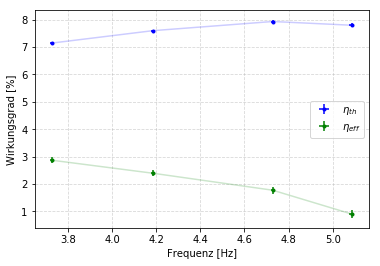

In [17]:
plt.errorbar(x=ff, y=eta_th*100, xerr=dff, yerr=deta_th*100, fmt='.', color='blue', label='$\eta_{th}$')
plt.errorbar(x=ff, y=eta_eff*100, xerr=dff, yerr=deta_eff*100, fmt='.', color='green', label='$\eta_{eff}$')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('Frequenz [Hz]')
plt.ylabel('Wirkungsgrad [%]')
plt.plot(ff, eta_th*100, color='blue', alpha=0.2)
plt.plot(ff, eta_eff*100, color='green', alpha=0.2)
plt.legend(loc='center right')
plt.savefig('./output/Wirkungsgrade.pdf', format='PDF')